# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [ ]:
import copy
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torchvision.datasets as datasets
from PIL import Image
import random
from torchvision import transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([transforms.ToTensor()])

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
!pip install scipy==1.1.0
!pip install scikit-learn==0.20

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()
attrs

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.17712,-0.111313,-0.154603,-1.03151,2.39246,-0.191576,1.2279,-1.3818,-1.52885,0.907964,-1.32429,-0

In [ ]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
# у нас цветные изображения
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE


Разбейте выборку картинок на train и val:

In [ ]:
X_train = data[0:TRAIN_SIZE]
X_val = data[TRAIN_SIZE:]
X_train.shape

(10000, 45, 45, 3)

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

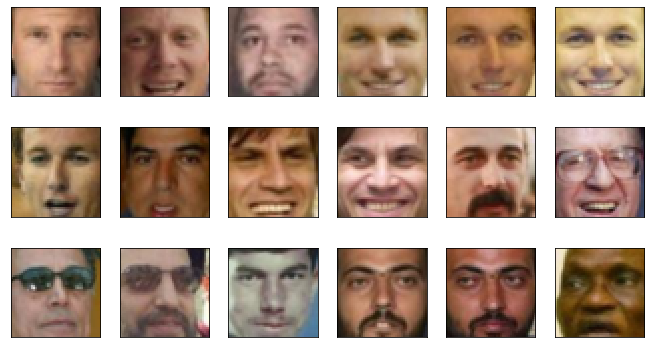

In [ ]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [ ]:
X_train = torch.FloatTensor(X_train/255.).to(device).permute(0, 3, 1, 2)
X_val = torch.FloatTensor(X_val/255.).to(device).permute(0, 3, 1, 2)
print(X_val.shape)
train_loader = DataLoader(dataset=X_train, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset=X_val, batch_size=64, shuffle=False, num_workers=0)

torch.Size([3143, 3, 45, 45])


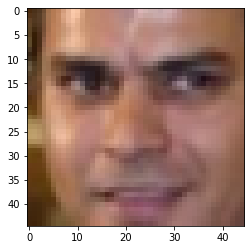

In [ ]:
for i in test_loader:
  plt.imshow(i[0].permute(1, 2, 0).detach().cpu().numpy())
  break

In [ ]:
from torchvision.datasets import MNIST
train_data = MNIST('./data', train=True, transform=transform, download=True)
test_data = MNIST('./data', train=False, transform=transform, download=True)
mnist_train_dataloader = DataLoader(train_data, 64, num_workers=0, shuffle=False)
mnist_test_dataloader = DataLoader(test_data, 64, num_workers=0)

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [ ]:
inp_size=X_train.shape[1]
dim_code = 100 # размер латентного вектора, т.е. code

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
class Autoencoder_mnist(nn.Module):
    def __init__(self):
        super(Autoencoder_mnist, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),

            nn.Linear(1024,2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(),

            nn.Linear(2048, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),

        )
        self.decoder = nn.Sequential(
            
            nn.Linear(100,2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(),

            nn.Linear(2048,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),

            nn.Linear(1024, 28*28)
        )
    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        
        return recon, latent

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(45*45*3,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),

            nn.Linear(1024,2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(),

            nn.Linear(2048, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),

        )
        self.decoder = nn.Sequential(
            
            nn.Linear(100,2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(),

            nn.Linear(2048,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),

            nn.Linear(1024,45*45*3)
        )
    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        
        return recon, latent

In [ ]:
criterion = nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
def train(model, X_train, X_val, loss_func, optimizer, epoches):
  losses_train = []
  losses_val = []
  losses_t = []
  losses_v = []
  for epoch in range(epoches):
    model.train()
    for X in X_train:
      X = X.view(-1, 3*45*45)
      pred, latent = model(X)
      loss = loss_func(pred, X)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      losses_t.append(float(loss))
    losses_train.append(sum(losses_t)/len(losses_t))
    losses_t = []
    if epoch % 10 == 0:
      model.eval()
      for Y in X_val:
        Y = Y.view(-1, 3*45*45)
        pred, latent = model(Y)
        loss = loss_func(pred, Y)
        losses_v.append(float(loss))
      losses_val.append(sum(losses_v)/len(losses_v))
      losses_v = []
      fig, axes = plt.subplots(1, 2)
      axes[0].imshow(Y[0].view(3, 45, 45).permute(1,2,0).detach().cpu().numpy())
      axes[1].imshow(pred[0].view(3, 45, 45).permute(1,2,0).detach().cpu().numpy())
      plt.show()
      print(losses_val[-1])
  return np.array(losses_train), np.array(losses_val)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

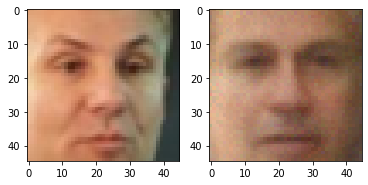

0.015733521580696106


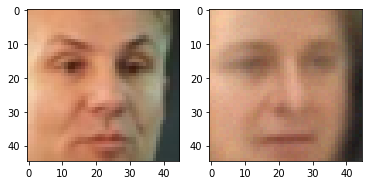

0.008750910926610232


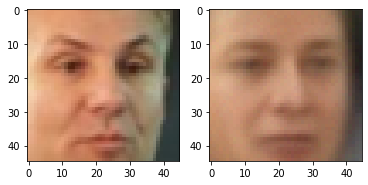

0.008315940164029598


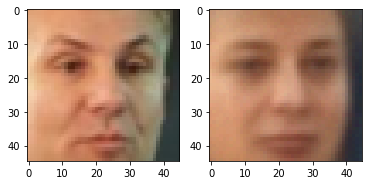

0.007347758337855339


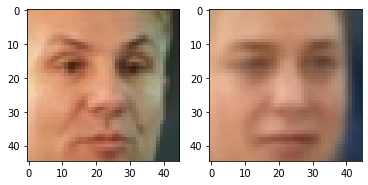

0.006091571720317006


In [ ]:
loss_train_ae, loss_val_ae = train(autoencoder, train_loader, test_loader, criterion, optimizer, 50)

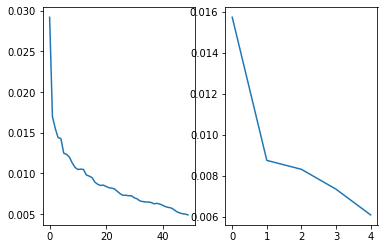

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(loss_train_ae)
axes[1].plot(loss_val_ae)

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([25, 6075])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

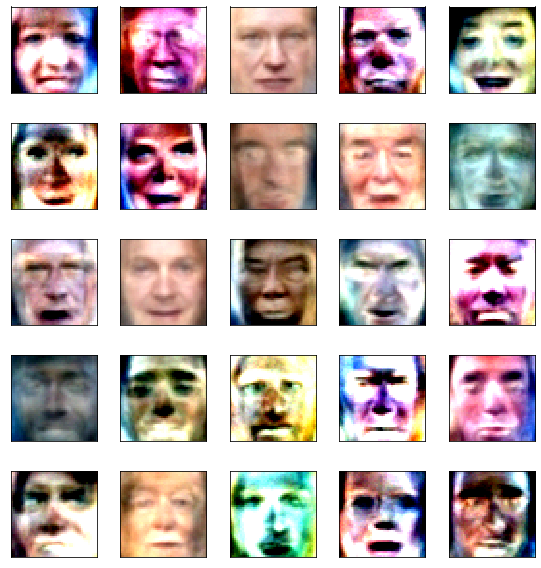

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, 100)
output = autoencoder.decoder(torch.FloatTensor(z).to(device))
print(output.shape)
plot_gallery(output.view(25, 3, 45, 45).data.permute(0,2,3,1).cpu().numpy(), 45, 45, n_row=5, n_col=5)

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

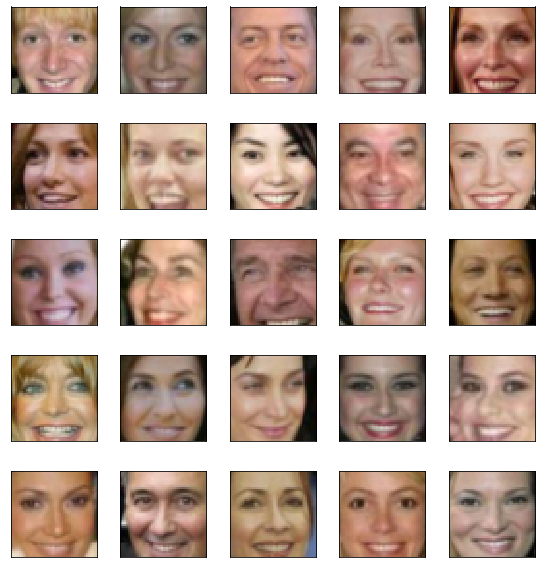

In [ ]:
smile_index = attrs['Smiling'].sort_values(ascending=False).iloc[200:230].index.values
smile_imges = torch.FloatTensor(data[smile_index]/255.).to(device).permute(0, 3, 1, 2)

sad_index = attrs['Smiling'].sort_values(ascending=True).iloc[:30].index.values
sad_imges = torch.FloatTensor(data[sad_index]/255.).to(device).permute(0, 3, 1, 2)

plot_gallery(smile_imges.permute(0, 2, 3, 1).detach().cpu().numpy(), 45, 45, 5, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
Clippi

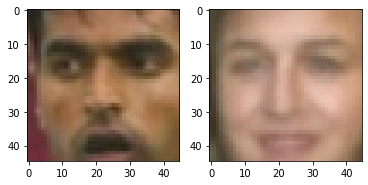

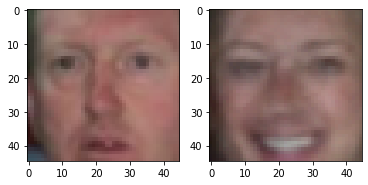

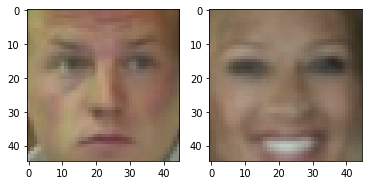

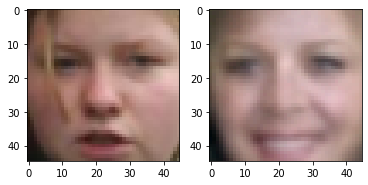

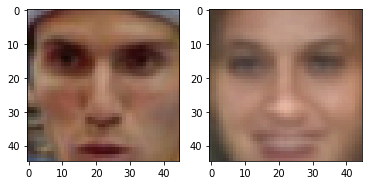

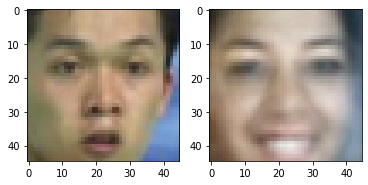

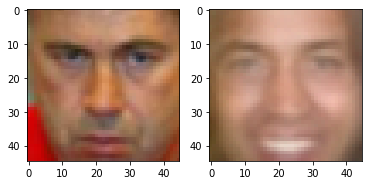

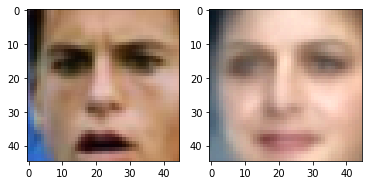

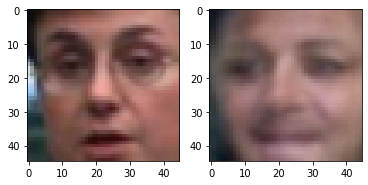

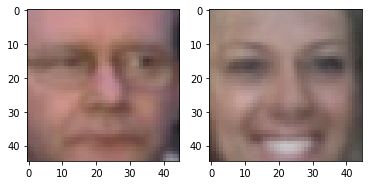

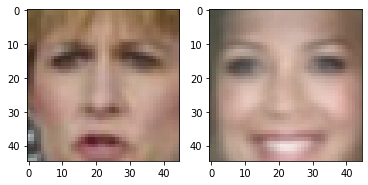

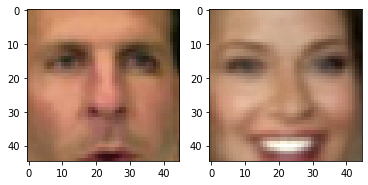

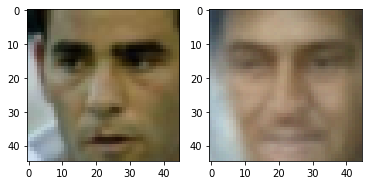

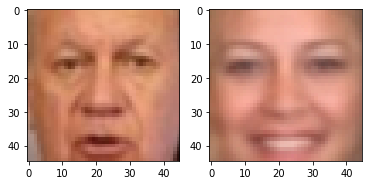

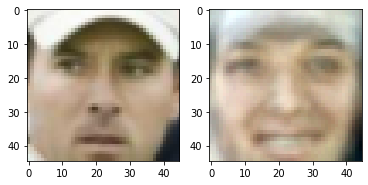

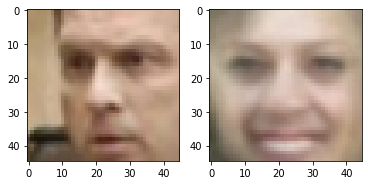

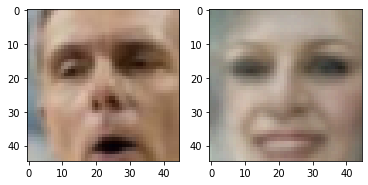

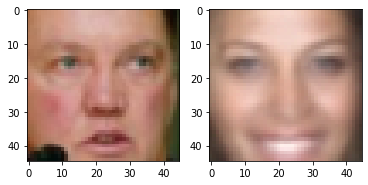

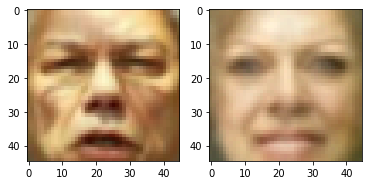

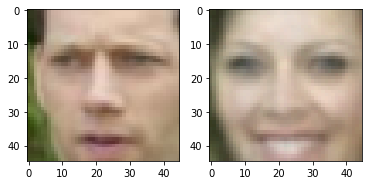

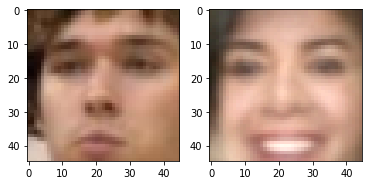

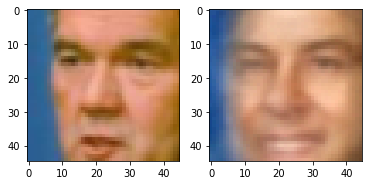

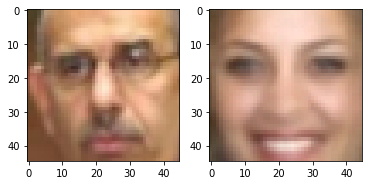

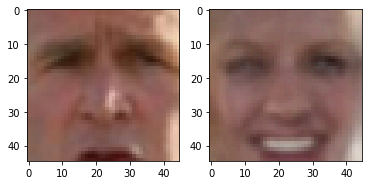

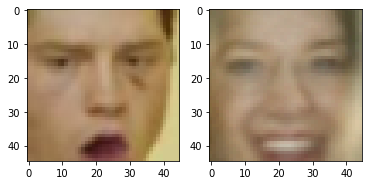

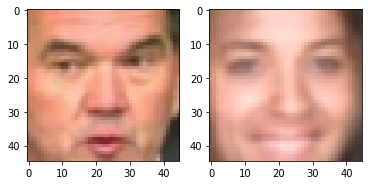

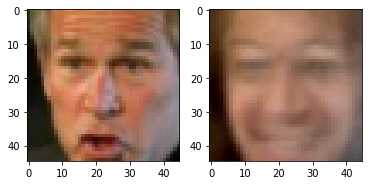

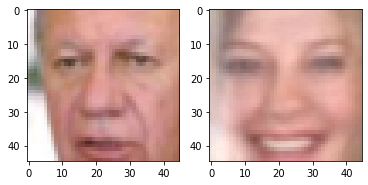

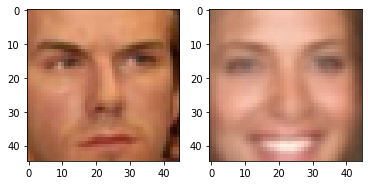

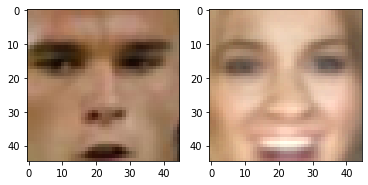

In [ ]:
def get_vector(imges):
  autoencoder.eval()
  imges = autoencoder.encoder(imges.reshape(-1, 3*45*45))
  return imges.mean(axis=0)

def get_new_imges(imges, vector):
    autoencoder.eval()
    images = []
    for i in range(len(imges)):
      img = autoencoder.encoder(imges[i].reshape(-1, 3*45*45))
      img += vector
      images.append(autoencoder.decoder(img).view(3, 45, 45))
    return images

smile_vector = get_vector(smile_imges) - get_vector(sad_imges)
new_smile_imges = get_new_imges(sad_imges, smile_vector)

for i in range(len(new_smile_imges)):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(sad_imges[i].permute(1, 2, 0).detach().cpu().numpy())
    axes[1].imshow(new_smile_imges[i].permute(1, 2, 0).detach().cpu().numpy())

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (2 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [ ]:
class VAE_mnist(nn.Module):
    def __init__(self):
        super(VAE_mnist, self).__init__()
        self.fc0 = nn.Linear(28*28, 1024)
        self.fc1_0 = nn.Linear(1024, 100)
        self.fc1_1 = nn.Linear(1024, 100)
        self.fc2 = nn.Linear(100, 1024)
        self.fc3 = nn.Linear(1024, 28*28)

    def encode(self, x):
        x = F.relu(self.fc0(x))
        return self.fc1_0(x), self.fc1_1(x)

    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5 *logsigma)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        z = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(z))

    def forward(self, x):
        mu, logsigma = self.encode(x)
        reconstruction= self.reparameterize(mu, logsigma)
        reconstruction = self.decode(reconstruction)
        return mu, logsigma, reconstruction
    


In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc0 = nn.Linear(45*45*3, 1024)
        self.fc1_0 = nn.Linear(1024, 100)
        self.fc1_1 = nn.Linear(1024, 100)
        self.fc2 = nn.Linear(100, 1024)
        self.fc3 = nn.Linear(1024, 45*45*3)

    def encode(self, x):
        x = nn.LeakyReLU()(self.fc0(x))
        return self.fc1_0(x), self.fc1_1(x)

    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5 *logsigma)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        z = nn.LeakyReLU()(self.fc2(z))
        return torch.sigmoid(self.fc3(z))

    def forward(self, x):
        mu, logsigma = self.encode(x)
        reconstruction= self.reparameterize(mu, logsigma)
        reconstruction = self.decode(reconstruction)
        return mu, logsigma, reconstruction
    


Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
criterion_vae = loss_vae

autoencoder_vae = VAE().to(device)

optimizer_vae = torch.optim.Adam(autoencoder_vae.parameters())

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
def train_vae(model, optimizer, loss_fc, train_X, test_X, epoches=100):
  loss_train = []
  loss_val = []
  for epoch in range(epoches):
    loss_t = []
    loss_v = []
    model.train()
    for X in train_X:
      X = X.view(-1, 45*45*3)
      optimizer.zero_grad()
      mu, logsigma, reconstraction = model.forward(X)
      loss = loss_fc(X, mu, logsigma, reconstraction)
      loss.backward()
      optimizer.step()
      loss_t.append(float(loss))
    loss_train.append(sum(loss_t)/len(loss_t))
    if epoch % 10 == 0:
      model.eval()
      for Y in test_X:
        Y = Y.view(-1, 45*45*3)
        mu, logsigma, reconstraction = model.forward(Y)
        loss = loss_fc(Y, mu, logsigma, reconstraction)
        loss_v.append(loss)
      loss_val.append(sum(loss_v)/len(loss_v))
      fig, axes = plt.subplots(1, 2)
      axes[0].imshow(Y[0].view(3, 45, 45).permute(1,2,0).detach().cpu().numpy())
      axes[1].imshow(reconstraction[0].view(3, 45, 45).permute(1,2,0).detach().cpu().numpy())
      plt.show()
  return loss_train, loss_val

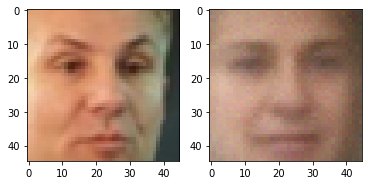

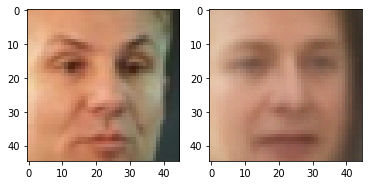

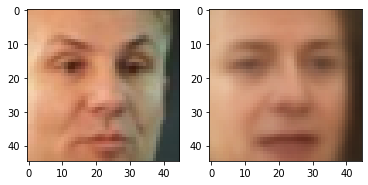

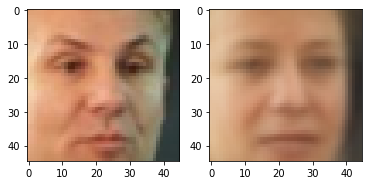

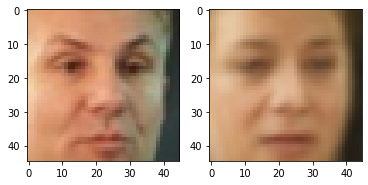

In [ ]:
loss_train_vae, loss_val_vae = train_vae(autoencoder_vae, optimizer_vae, criterion_vae, train_loader, test_loader, 50)

tensor(235445.6875, device='cuda:0', grad_fn=<DivBackward0>)


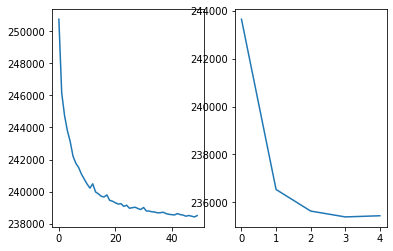

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(loss_train_vae)
axes[1].plot(loss_val_vae)
print(loss_val_vae[-1])

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

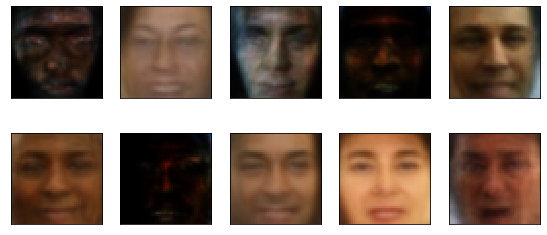

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 100) for i in range(10)])
output = autoencoder_vae.decode(torch.FloatTensor(z).to(device))
plot_gallery(output.data.view(10, 3, 45, 45).permute(0,2,3,1).cpu().numpy(), 45, 45, n_row=2, n_col=5)

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [ ]:
from sklearn.manifold import TSNE

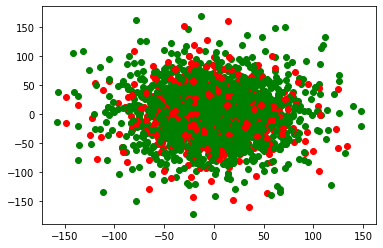

In [ ]:
index = 10000
men = []
women = []
autoencoder_vae.eval()
for Y in test_loader:
    mu, logsigma= autoencoder_vae.encode(Y.view(-1, 45*45*3))
    output = autoencoder_vae.reparameterize(mu, logsigma)
    output = TSNE(n_components=2).fit_transform(output.detach().cpu())
    for i in output:
      if attrs["Male"][index] > 0:
        plt.scatter(i[0], i[1], color = "green")
      else:
        plt.scatter(i[0], i[1], color = "red")
      index += 1
plt.show()

Что вы думаете о виде латентного представления?

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        self.fc0 = nn.Linear(28*28+10, 1024)
        self.fc1_0 = nn.Linear(1024, 100)
        self.fc1_1 = nn.Linear(1024, 100)
        self.fc2 = nn.Linear(100 + 10, 1024)
        self.fc3 = nn.Linear(1024, 28*28)

    def encode(self, x):
        x = nn.LeakyReLU()(self.fc0(x))
        return self.fc1_0(x), self.fc1_1(x)
      
    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5 *logsigma)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        z = nn.LeakyReLU()(self.fc2(z)) 
        return torch.sigmoid(self.fc3(z))

    def forward(self, x, labels):
        mu, logsigma = self.encode(torch.cat((x, labels), dim=1))
        reconstruction= self.reparameterize(mu, logsigma)
        reconstruction = self.decode(torch.cat((reconstruction, labels), dim=1))
        return mu, logsigma, reconstruction
    


In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

def idx2onehot(idx, n=10):
    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx.data, 1)

    return onehot

In [ ]:
criterion_cvae = loss_vae

autoencoder_cvae = CVAE().to(device)

optimizer_cvae = torch.optim.Adam(autoencoder_cvae.parameters())

In [ ]:
def train_cvae(model, optimizer, loss_fc, train_X, test_X, epoches=100):
  loss_train = []
  loss_val = []
  for epoch in range(epoches):
    model.train()
    loss_t = []
    loss_v = []
    for i, (X, label) in enumerate(train_X):
      labels = label.view(-1, 1)
      labels = torch.zeros(labels.shape[0], 10).scatter_(1, labels.data, 1).to(device)
      X = X.view(-1, 28*28).to(device)
      optimizer.zero_grad()
      mu, logsigma, reconstraction = model.forward(X, labels)
      loss = loss_fc(X, mu, logsigma, reconstraction)
      loss.backward()
      optimizer.step()
      loss_t.append(float(loss))
    loss_train.append(sum(loss_t)/len(loss_t))
    if epoch % 10 == 0:
      model.eval()
      for i, (Y, label) in enumerate(test_X):
        labels = label.view(-1, 1)
        labels = torch.zeros(labels.shape[0], 10).scatter_(1, labels.data, 1).to(device)
        Y = Y.view(-1, 28*28).to(device)
        mu, logsigma, reconstraction = model.forward(Y, labels)
        loss = loss_fc(Y, mu, logsigma, reconstraction)
        loss_v.append(loss)
      loss_val.append(sum(loss_v)/len(loss_v))
      fig, axes = plt.subplots(1, 2)
      axes[0].imshow(Y[9].view(28, 28).detach().cpu().numpy())
      axes[1].imshow(reconstraction[9].view(28, 28).detach().cpu().numpy())
      plt.show()
  return loss_train, loss_val

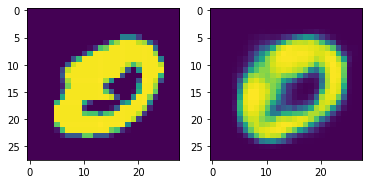

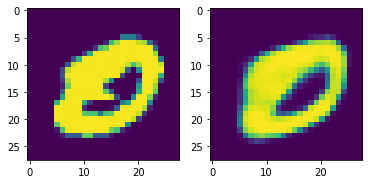

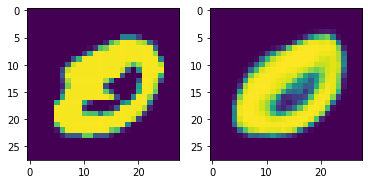

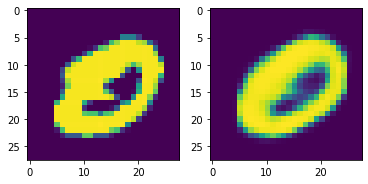

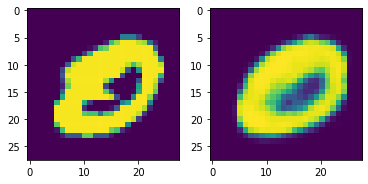

In [ ]:
loss_train_cvae, loss_val_cvae = train_cvae(autoencoder_cvae, optimizer_cvae, criterion_cvae, mnist_train_dataloader, mnist_test_dataloader, 50)

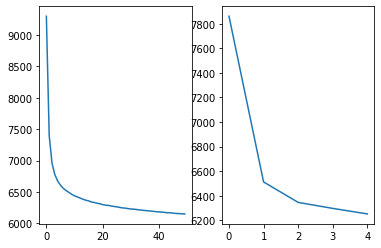

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(loss_train_cvae)
axes[1].plot(loss_val_cvae)

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

0


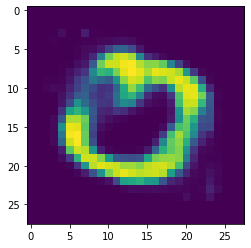

1


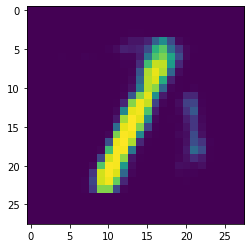

2


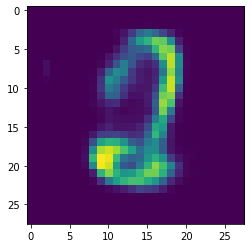

3


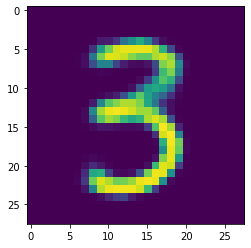

4


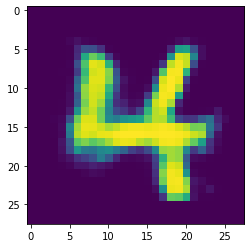

5


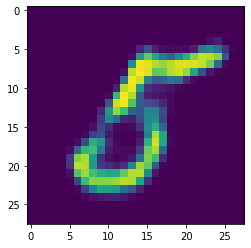

6


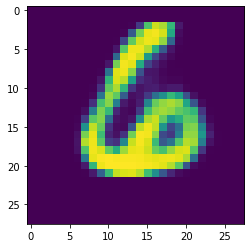

7


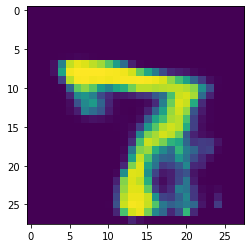

8


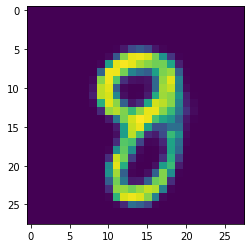

9


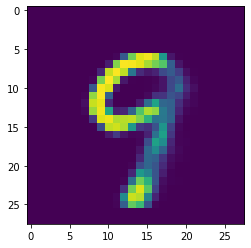

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(10, 100)
ind = 0
for i in range(10):
  labels = torch.zeros(10)
  labels[ind] = 1 
  rez = torch.cat((torch.FloatTensor(z[i]), labels), dim=0).to(device)
  output = autoencoder_cvae.decode(rez)
  print(ind)
  plt.imshow(output.view(28, 28).detach().cpu().numpy())
  plt.show()
  ind += 1 

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

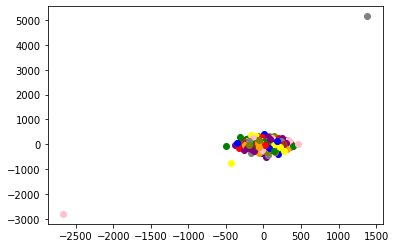

In [ ]:
index = 10000
men = []
women = []
colors = {0:"red", 1:"orange", 2:"yellow", 3:"green", 4:"blue", 5:"olive", 6:"purple", 7:"grey", 8:"brown", 9:"pink"}
for i, (Y, label) in enumerate(mnist_test_dataloader):
    labels = label.view(-1, 1)
    labels = torch.zeros(labels.shape[0], 10).scatter_(1, labels.data, 1)
    rez = torch.cat((Y.view(-1, 28*28), labels), dim=1).to(device)
    autoencoder_cvae.eval()
    mu, logsigma = autoencoder_cvae.encode(rez)
    output = autoencoder_cvae.reparameterize(mu, logsigma)
    output = TSNE(n_components=2).fit_transform(output.detach().cpu())
    for i in range(len(output)):
      plt.scatter(output[i][0], output[i][1], color = colors[int(label[i])])
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

In [ ]:
criterion_morphing = nn.MSELoss()
autoencoder_morphing = copy.copy(autoencoder)
optimizer_morphing = torch.optim.Adam(autoencoder_morphing.parameters())

In [ ]:
def train_morphing(model, optimizer, loss_fc, train_X, test_X, a = 0.4, epoches=100):
  loss_train = []
  loss_val = []
  for epoch in range(epoches):
    model.train()
    loss_t = []
    loss_v = []
    x0_iter = iter(train_X)
    target_iter_x = iter(train_X)
    target = next(target_iter_x)
    for i in range(10000//128-1):
      X0 = next(x0_iter)
      target = next(target_iter_x)
      X0 = X0.view(-1, 45*45*3)
      X1 = target.view(-1, 45*45*3)
      X0 = model.encoder(X0)
      X1 = model.encoder(X1)
      X = X0*a + X1*(1-a)
      optimizer.zero_grad()
      pred = model.decoder(X)
      loss = loss_fc(pred, target.view(-1, 45*45*3))
      loss.backward()
      optimizer.step()
      loss_t.append(float(loss))
    loss_train.append(sum(loss_t)/len(loss_t))
    if epoch % 10 == 0:
      model.eval()
      y0_iter = iter(test_X)
      target_iter_y = iter(test_X)
      target = next(target_iter_y)
      for j in range(3143//128-1):
        start = next(y0_iter)
        target = next(target_iter_y)
        Y0 = start.view(-1, 45*45*3)
        Y1 = target.view(-1, 45*45*3)
        Y0 = model.encoder(Y0)
        Y1 = model.encoder(Y1)
        Y = Y0*a + Y1*(1-a)

        pred = model.decoder(Y)
        loss = loss_fc(pred, target.view(-1, 45*45*3))
        loss_v.append(loss)
      loss_val.append(sum(loss_v)/len(loss_v))
      fig, axes = plt.subplots(1, 3)
      print(loss_val[-1])
      axes[0].imshow(start[-1].view(3, 45, 45).permute(1,2,0).detach().cpu().numpy())
      axes[1].imshow(target[-1].view(3, 45, 45).permute(1,2,0).detach().cpu().numpy())
      axes[2].imshow(pred[-1].view(3, 45, 45).permute(1,2,0).detach().cpu().numpy())
      plt.show()
  return loss_train, loss_val

tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)


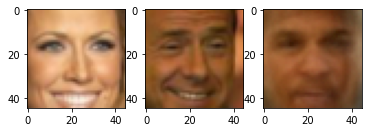

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0083, device='cuda:0', grad_fn=<DivBackward0>)


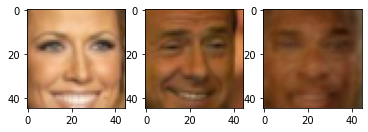

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)


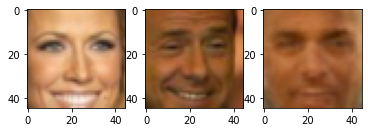

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0072, device='cuda:0', grad_fn=<DivBackward0>)


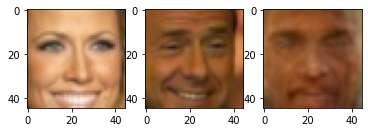

tensor(0.0074, device='cuda:0', grad_fn=<DivBackward0>)


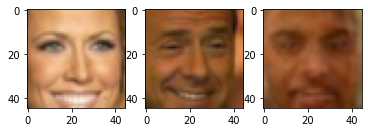

tensor(0.0077, device='cuda:0', grad_fn=<DivBackward0>)


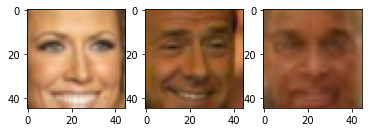

tensor(0.0083, device='cuda:0', grad_fn=<DivBackward0>)


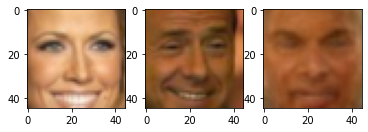

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)


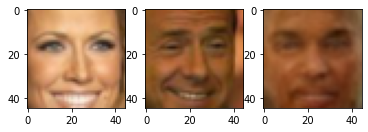

tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)


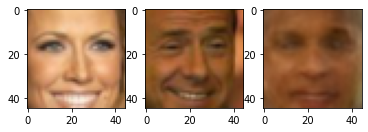

tensor(0.0087, device='cuda:0', grad_fn=<DivBackward0>)


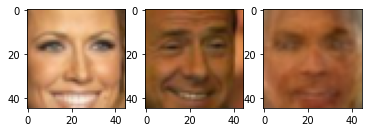

In [ ]:
loss_train_morph, loss_val_morph = train_morphing(autoencoder_morphing, optimizer_morphing, criterion_morphing, train_loader, test_loader, 0.05, 100)

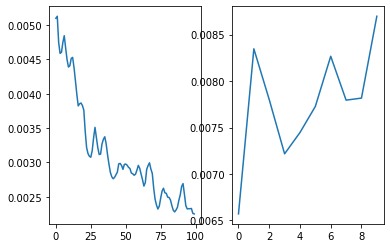

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(loss_train_morph)
axes[1].plot(loss_val_morph)

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
def make_noise(data, noise_factor=0.5):
  data = data + torch.FloatTensor(noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)).to(device)
  return data

In [ ]:
criterion_noisy = nn.MSELoss()
autoencoder_noisy = Autoencoder_mnist().to(device)
optimizer_noisy = torch.optim.Adam(autoencoder_noisy.parameters())

In [ ]:
def train_noisy(model, X_train, X_val, loss_func, optimizer, epoches=50):
  losses_train = []
  losses_val = []
  losses_t = []
  losses_v = []
  for epoch in range(epoches):
    model.train()
    for i, (X, label) in enumerate(X_train):
      X = torch.FloatTensor(X).to(device)
      target = copy.copy(X)
      X = make_noise(X)
      X = X.view(-1, 28*28)
      pred, latent = model(X)
      loss = loss_func(pred, target.view(-1, 28*28))
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      losses_t.append(float(loss))
    losses_train.append(sum(losses_t)/len(losses_t))
    losses_t = []
    if epoch % 10 == 0:
      model.eval()
      for Y in X_val:
        Y = torch.FloatTensor(Y[0]).to(device)
        target = copy.copy(Y)
        Y = make_noise(Y)
        Y = Y.view(-1, 28*28)
        pred, latent = model(Y)
        loss = loss_func(pred, target.view(-1, 28*28))
        losses_v.append(float(loss))
      losses_val.append(sum(losses_v)/len(losses_v))
      losses_v = []
      print(losses_val[-1])
      fig, axes = plt.subplots(1, 3)
      axes[0].imshow(target[-1].view(28, 28).detach().cpu().numpy())
      axes[1].imshow(Y[-1].view(28, 28).detach().cpu().numpy())
      axes[2].imshow(pred[-1].view(28, 28).detach().cpu().numpy())
      plt.show()
  return losses_train, losses_val

0.025477103900852477


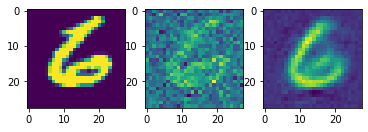

0.015003518047179006


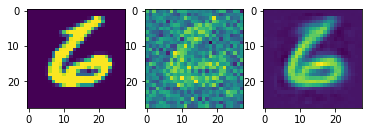

0.013797230757535642


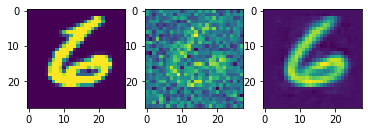

0.012146440441393928


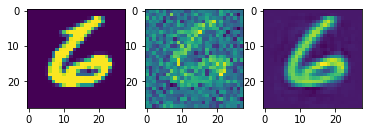

0.011876708311829597


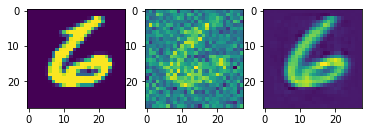

In [ ]:
loss_train_noisy, loss_val_noisy = train_noisy(autoencoder_noisy, mnist_train_dataloader, mnist_test_dataloader, criterion_noisy, optimizer_noisy, 50)

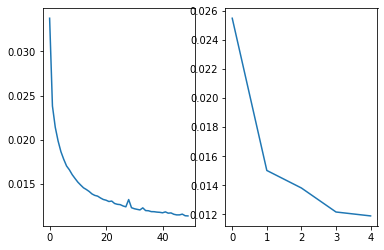

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(loss_train_noisy)
axes[1].plot(loss_val_noisy)

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [ ]:
def make_spot(imgs):
  x = random.randint(8, 22)
  y = random.randint(6, 22)
  diffx = random.randint(6, 9)
  diffy = random.randint(6, 9)
  if x + diffx > 22:
    x = 22 - diffx
  if y + diffy > 22:
    y = 22 - diffy
  imgs = imgs.reshape(-1, 28, 28)
  imgs[:, x : x + diffx, y : y + diffy] = torch.FloatTensor(np.zeros((diffx, diffy)))
  return imgs

In [ ]:
autoencoder_occ = VAE_mnist().to(device)
optimizer_occ = torch.optim.Adam(autoencoder_occ.parameters(), 0.00025)
criterion_vae_occ = loss_vae

In [ ]:
def train_vae_occ(model, optimizer, loss_fc, train_X, test_X, epoches=100):
  loss_train = []
  loss_val = []
  for epoch in range(epoches):
    model.train()
    loss_t = []
    loss_v = []
    for i, (X, label) in enumerate(train_X):
      target = copy.copy(X).to(device)
      X = make_spot(X)
      X = X.view(-1, 28*28).to(device)
      optimizer.zero_grad()
      mu, logsigma, reconstraction = model.forward(X)
      loss = loss_fc(target.view(-1, 28*28), mu, logsigma, reconstraction)
      loss.backward()
      optimizer.step()
      loss_t.append(loss)
    loss_train.append(sum(loss_t)/len(loss_t))
    if epoch % 10 == 0:
      model.eval()
      for i, (Y, label) in enumerate(test_X):
        target = copy.copy(Y).to(device)
        Y = make_spot(Y)
        Y = Y.view(-1, 28*28).to(device)
        mu, logsigma, reconstraction = model.forward(Y)
        loss = loss_fc(target.view(-1, 28*28), mu, logsigma, reconstraction)
        loss_v.append(loss)
      loss_val.append(sum(loss_v)/len(loss_v))
      print(loss_val[-1])
      fig, axes = plt.subplots(1, 2)
      axes[0].imshow(Y[-1].view(28, 28).detach().cpu().numpy())
      axes[1].imshow(reconstraction[-1].view(28, 28).detach().cpu().numpy())
      plt.show()
  return loss_train, loss_val

tensor(9798.1719, device='cuda:0', grad_fn=<DivBackward0>)


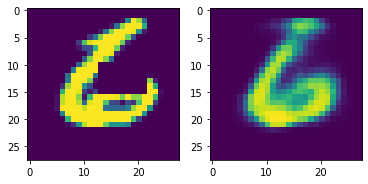

tensor(7349.2905, device='cuda:0', grad_fn=<DivBackward0>)


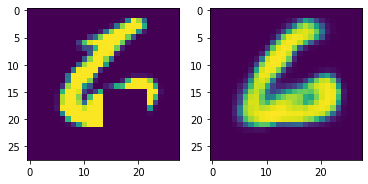

tensor(7093.3267, device='cuda:0', grad_fn=<DivBackward0>)


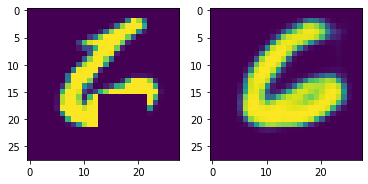

tensor(6983.5400, device='cuda:0', grad_fn=<DivBackward0>)


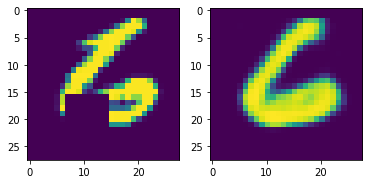

tensor(6875.9795, device='cuda:0', grad_fn=<DivBackward0>)


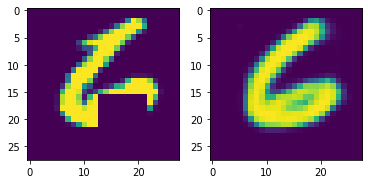

In [ ]:
loss_train_occ, loss_val_occ = train_vae_occ(autoencoder_occ, optimizer_occ, criterion_vae_occ, mnist_train_dataloader, mnist_test_dataloader, 50)

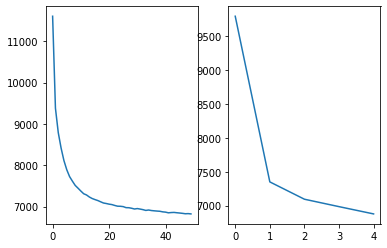

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(loss_train_occ)
axes[1].plot(loss_val_occ)

# Bonus 3: Image Retrieval (2 балла)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
mu, logvar = autoencoder_vae.encode(X_train.reshape(-1, 45*45*3))
codes = autoencoder_vae.reparameterize(mu, logvar)

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes.detach().cpu())

/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/approximate.py:258: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  mu, logvar = autoencoder_vae.encode(image.reshape(-1, 45*45*3).to(device))
  code = autoencoder_vae.reparameterize(mu, logvar)

  (distances,),(idx,) = lshf.kneighbors(code.detach().cpu(), n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    distances,neighbors = get_similar(image.reshape(-1, 45*45*3),n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

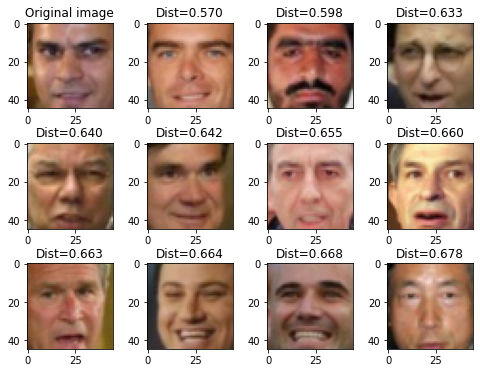

In [ ]:
show_similar(X_val[0])